## Install required dependencies

In [82]:
import sys
!{sys.executable} -m pip install scikit-learn numpy pandas plotly


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/bin/python -m pip install --upgrade pip


## Prepare training and testing dataset (HW point 1)

In [3]:
import codecs
import random

lista=[]
with codecs.open("dataset.txt","r","UTF-8") as file:
    for line in file:
        elements=(line.strip('\n')).split(",")
        temp=[str(float(x)) for x in elements]
        if temp[-1]=="0.0":
            temp[-1]="Absence"
        else:    
            temp[-1]="Present"
        lista.append(temp)

random.shuffle(lista)

print("training dataset")
with codecs.open("training.txt","w","UTF-8") as file:
    for x in lista[:242]:
        file.write(",".join(x)+"\n")

print("test dataset")
with codecs.open("test.txt","w","UTF-8") as file:
    for x in lista[242:]:
        file.write(",".join(x)+"\n")    

training dataset
test dataset


In [4]:
import math

def euclidean_distance(v1, v2):
    sum_squared_differences = sum((x2-x1)**2 for x1, x2 in zip(v1, v2))
    return math.sqrt(sum_squared_differences) 

## Manhattan distance function for computing the distance between vectors (HW point 2)

I found out Manhattan distance gave better results than euclidean distance for multidimensional vectors

In [5]:
def manhattan_distance(v1, v2) -> float:
    return sum(abs(x2 - x1) for x1, x2 in zip(v1, v2))

## Cosine similarity distance function for computing the distance between vectors (HW point 3)

In [6]:
import numpy as np

def cosine_similarity(v1, v2) -> float:
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    
    return dot_product / (norm_v1 * norm_v2)

## Classify function (KNN model)

In [7]:
from statistics import mode
from typing import List

def classify(test_vector: List, data_attributes: List[List], data_labels: List, k: int, distance_function = manhattan_distance) -> str:
    distances=[]
    #For every vector in our dataset:
    for vector, label in zip(data_attributes,data_labels):
        #Calculate the distance between each of the dataset vectors and the test vector
        distance = distance_function(vector,test_vector)
        distances.append((distance,label))
        
    #Sort the distances in increasing order
    distances.sort(key= lambda x: x[0])
    votelabels=[]
    
    #Take k items with lowest distances to test list
    for x in distances[:k]:
        votelabels.append(x[1])
        
    #Find the majority class among these items and return the majority class as prediction
    return mode(votelabels)

## Prepare samples function

In [8]:
from typing import Tuple

def prepare_samples(fileroute: str) -> Tuple[List, List]:
    vectors = []
    labels = []
    with codecs.open(fileroute,"r","UTF-8") as file:
        for line in file:
            elements=(line.rstrip('\n')).split(",")
            vectors.append([float(e) for e in elements[:-1]])
            labels.append(elements[-1])
    
    return vectors, labels

## Test analog KNN model with different K's to determine the best for this case (HW points 4, 5, 6)

In [9]:
from typing import Tuple

training, training_labels = prepare_samples("training.txt")
test, test_labels = prepare_samples("test.txt")

def test_knn(training, training_labels, test, test_labels, k) -> Tuple[int, float]:
    correct_predictions = 0
    for vector, label in zip(test, test_labels):
        predicted = classify(vector, training, training_labels, k)
        if predicted == label:
            correct_predictions += 1

    print(f"k: {k}, correct_predictions: {correct_predictions}")

    print(f"model accuracy: {(correct_predictions/len(test))*100}")
    return k, correct_predictions


results = []
for k in range(3, 42):
    results.append(test_knn(training, training_labels, test, test_labels, k))

best_manual_k = max(results, key= lambda x: x[1])

print(f"KNN best manual k: {best_manual_k}")    

k: 3, correct_predictions: 41
model accuracy: 67.21311475409836
k: 4, correct_predictions: 44
model accuracy: 72.1311475409836
k: 5, correct_predictions: 42
model accuracy: 68.85245901639344
k: 6, correct_predictions: 43
model accuracy: 70.49180327868852
k: 7, correct_predictions: 40
model accuracy: 65.57377049180327
k: 8, correct_predictions: 40
model accuracy: 65.57377049180327
k: 9, correct_predictions: 40
model accuracy: 65.57377049180327
k: 10, correct_predictions: 43
model accuracy: 70.49180327868852
k: 11, correct_predictions: 40
model accuracy: 65.57377049180327
k: 12, correct_predictions: 41
model accuracy: 67.21311475409836
k: 13, correct_predictions: 39
model accuracy: 63.934426229508205
k: 14, correct_predictions: 40
model accuracy: 65.57377049180327
k: 15, correct_predictions: 40
model accuracy: 65.57377049180327
k: 16, correct_predictions: 44
model accuracy: 72.1311475409836
k: 17, correct_predictions: 38
model accuracy: 62.295081967213115
k: 18, correct_predictions: 41
m

## Manual model insights (HW point 7)

Graph 1: Manhattan distances from training vectors to specific test vector

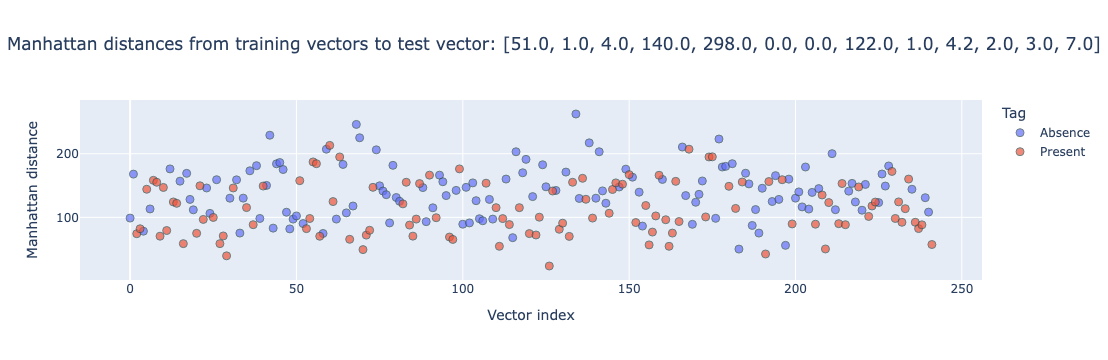

In [10]:
import plotly.express as px

training, training_labels = prepare_samples("training.txt")
test, _ = prepare_samples("test.txt")

manhattan_distances = [manhattan_distance(v, test[0]) for v in training]

fig = px.scatter(
    y=manhattan_distances,
    x=list(range(len(manhattan_distances))),
    color=training_labels,
    title=f"Manhattan distances from training vectors to test vector: {test[0]}",
    labels={
        'y': 'Manhattan distance',
        'x': 'Vector indecx',
        'color': 'Tag'
    }
)
fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    xaxis_title="Vector index",
    yaxis_title="Manhattan distance",
    title_x=0.5,
    legend_title_text='Tag'
)

fig.show()

Graph 2: confusion matrix 

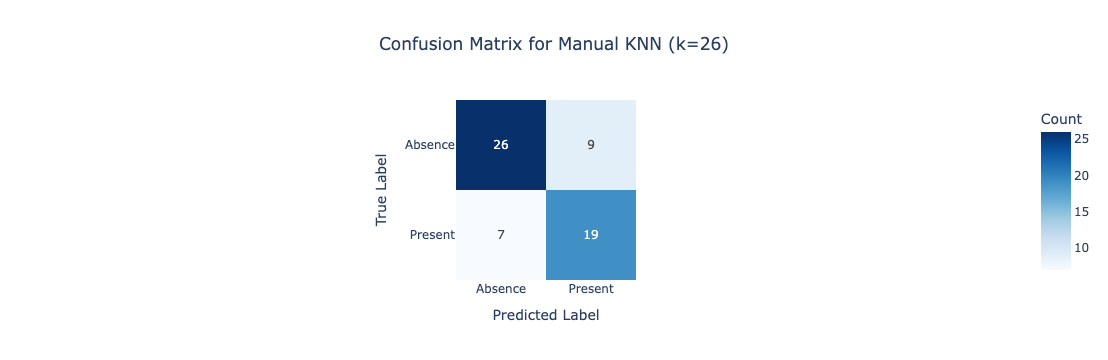

In [11]:
import plotly.express as px
from sklearn.metrics import confusion_matrix
import pandas as pd

best_k = best_manual_k[0]
predictions = [classify(vector, training, training_labels, best_k) for vector in test]

labels = ["Absence", "Present"]
cm = confusion_matrix(test_labels, predictions, labels=labels)

fig = px.imshow(cm,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=labels,
                y=labels,
                text_auto=True,
                color_continuous_scale='Blues',
                title=f"Confusion Matrix for Manual KNN (k={best_k})")

fig.update_layout(title_x=0.5)
fig.show()

## Insights and conclussion

**TODO**

## KNN with scikit-learn

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from typing import Tuple

training, training_labels = prepare_samples("training.txt")
test, test_labels = prepare_samples("test.txt")


def knn_sklearn(training, training_labels, test, test_labels, k: int=5, p: int = 1) -> Tuple[int, str, float]:
    distances_formulas = {
        1: "Manhattan",
        2: "Euclidean",
    }
    
    # Create the model object
    knn = KNeighborsClassifier(n_neighbors=k, p=p)
    
    # Train the model
    knn.fit(training, training_labels)
    
    # Make predictions on the test data
    predictions = knn.predict(test)

    # Evaluate the model performance
    accuracy = accuracy_score(test_labels,predictions)

    return k, distances_formulas.get(p, "Minkowski"), accuracy

## Model accuracies with different k parameter (HW sklearn point 1)

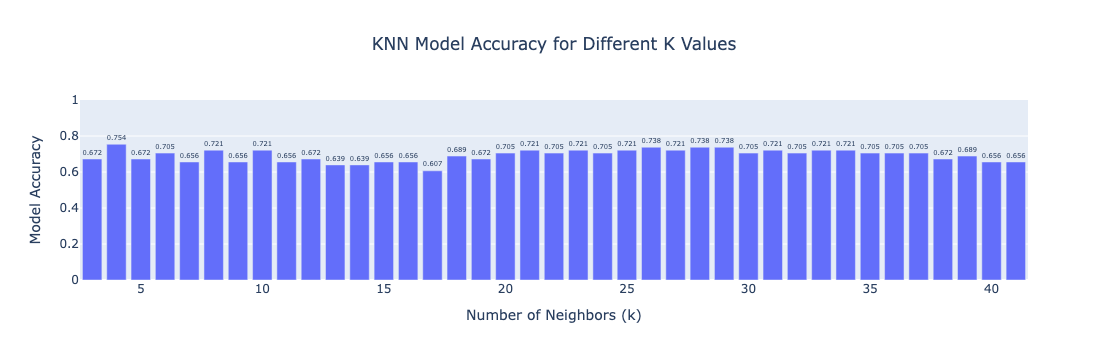

Best k value: 4


In [13]:
import plotly.express as px
import pandas as pd

different_k_results = []
for k in range(3, 42):
    different_k_results.append(knn_sklearn(training, training_labels, test, test_labels, k))

df_results = pd.DataFrame(different_k_results, columns=['k', 'distance_formula', 'accuracy'])

best_k_value = df_results.loc[df_results['accuracy'].idxmax()]['k']

fig = px.bar(
    data_frame=df_results,
    x='k',
    y='accuracy',
    title='KNN Model Accuracy for Different K Values',
    labels={
        'k': 'Number of Neighbors (k)',
        'accuracy': 'Model Accuracy'
    },
    text='accuracy'
)
fig.update_traces(
    texttemplate='%{text:.3f}',
    textposition='outside'
)
fig.update_layout(
    xaxis_title="Number of Neighbors (k)",
    yaxis_title="Model Accuracy",
    title_x=0.5,
    yaxis=dict(range=[0,1])
)

fig.show()

print(f"Best k value: {best_k_value}")

## Model accuracies with a different vector similarity criteria (HW sklearn point 2)

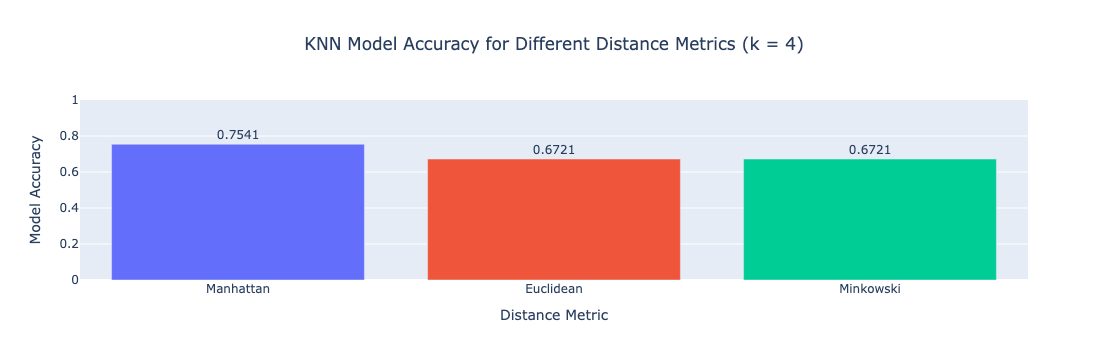

In [14]:
import plotly.express as px
import pandas as pd

different_similarity_results = []
for p in range(1,4):
    different_similarity_results.append(knn_sklearn(training, training_labels, test, test_labels, k=best_k_value, p=p))


df_similarity = pd.DataFrame(different_similarity_results, columns=['k', 'distance_formula', 'accuracy'])
fig = px.bar(
    data_frame=df_similarity,
    x='distance_formula',
    y='accuracy',
    color='distance_formula',
    title=f'KNN Model Accuracy for Different Distance Metrics (k = {best_k_value})',
    labels={
        'distance_formula': 'Distance Metric',
        'accuracy': 'Model Accuracy'
    },
    text='accuracy'
)

fig.update_traces(
    texttemplate='%{text:.4f}',
    textposition='outside'
)
fig.update_layout(
    xaxis_title="Distance Metric",
    yaxis_title="Model Accuracy",
    title_x=0.5,
    yaxis=dict(range=[0,1]),
    showlegend=False
)

fig.show()

## Confusion matrix for sklearn KNN for HW point 7

0.7540983606557377


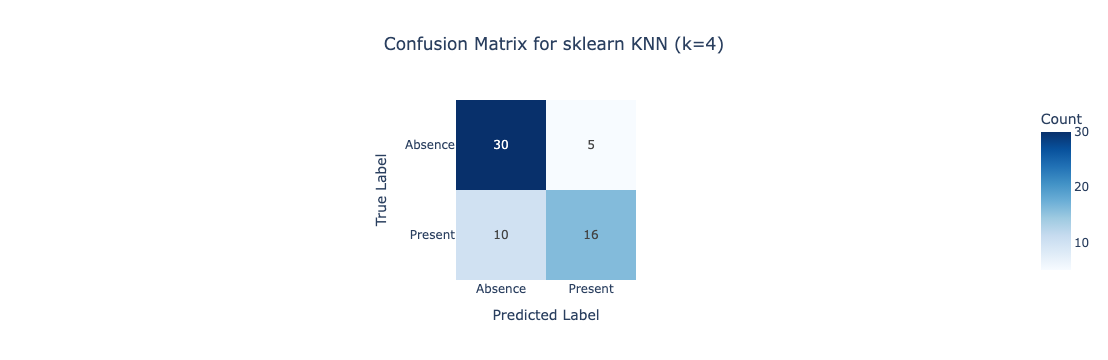

In [15]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

training, training_labels = prepare_samples("training.txt")
test, test_labels = prepare_samples("test.txt")

knn = KNeighborsClassifier(n_neighbors=best_k_value, p=1)
knn.fit(training, training_labels)
predictions = knn.predict(test)
accuracy = accuracy_score(test_labels,predictions)
print(accuracy)

labels = ["Absence", "Present"]
cm = confusion_matrix(test_labels, predictions, labels=labels)

fig = px.imshow(cm,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=labels,
                y=labels,
                text_auto=True,
                color_continuous_scale='Blues',
                title=f"Confusion Matrix for sklearn KNN (k={best_k_value})")

fig.update_layout(title_x=0.5)
fig.show()